# Agents with Human-in-the-Loop

We've tested two different email assistant, both of which can triage emails and use tools to respond to them. But do we actually *trust* them to manage our inbox? Few would trust an AI to manage their inbox without some human oversight immediately, which is why human-in-the-loop (HITL) is a critical pattern for many agent systems.

![overview-img](img/overview_hitl.png)

## Goal 

The goal is simple: we want to add a human-in-the-loop to our email assistant so that we can review specific tool calls, like sending an email! 

![overview-img](img/hitl_schematic.png)



Let' see this working in practice! Then, we'll explain it in detail below.

In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

import uuid
from langgraph.checkpoint.memory import MemorySaver
from email_assistant.email_assistant_hitl import overall_workflow

# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph
checkpointer = MemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_1 = uuid.uuid4()
thread_config_1 = {"configurable": {"thread_id": thread_id_1}}

# Run the graph until the first interrupt 
# Email will be classified as "respond" 
# Agent will create a schedule_meeting and write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

/Users/rlm/Desktop/Code/interrupt_workshop
Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-05-06', 'start_time': 14}}


Accept the `write_email` tool call

With the meeting scheduled, the agent now drafts a confirmation email to the client. The interrupt contains:

1. The email tool action with recipient, subject, and proposed content
2. The formatted email showing what will be sent
3. The same configuration options for user response types

When the user accepts, the email is sent as written. After this step, the agent marks the task as complete with the `Done` tool call, and the workflow ends. The complete message history shows all the steps taken:

1. Initial email processing
2. Calendar availability checks for both days
3. Meeting scheduling with confirmation
4. Email composition and sending
5. Workflow completion

In [2]:
from langgraph.types import Command

print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-05-06', 'start_time': 14}} tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hello,\n\nThank you for reaching out. I am available on Tuesday, May 6th at 2:00 PM for a 45-minute call to discuss tax planning strategies. I have scheduled the meeting accordingly.\n\nLooking forward to your suggestions.\n\nBest regards,\nLance'}}


In [3]:
from langgraph.types import Command

print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hello,\n\nThank you for reaching out. I am available on Tuesday, May 6th at 2:00 PM for a 45-minute call to discuss tax planning strategies. I have scheduled the meeting accordingly.\n\nLooking forward to your suggestions.\n\nBest regards,\nLance'}} tool call...


In [4]:
state = graph.get_state(thread_config_1)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Lance Martin <lance@company.com>

Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_gNfd9r9Mf0v2loaBBBu4IMKO)
 Call ID: call_gNfd9r9Mf0v2loaBBBu4IMKO
  Args:
    day: 2025-05-06
  check_calendar_availability (call_O0efy3MYO2CqlTEIP5CbFKwO)
 Call ID: call_O0efy3MYO2CqlTEIP5CbFKwO
  Args:
    day: 2025-05-08
================================= Tool Message =================================

Ava

## LangGraph Interrupts

The HITL (Human-In-The-Loop) pattern is useful for applications where decisions require human validation. LangGraph provides built-in support for this through its [interrupt mechanism](https://langchain-ai.github.io/langgraph/concepts/interrupts/), allowing us to pause execution of an agent and request human input when needed. Let's add HITL to our email assistant after specific tools are called.

### Simple Interrupt Example

First, let's just show a simple example for how to use the `interrupt` function. Assume we want a simple agent that can ask the user a question and then use that information. The `interrupt` function can be used for this purpose:

```
location = interrupt(ask.question)
```

When this line executes:
1. It raises a `GraphInterrupt` exception, which pauses the graph execution
2. It surfaces the value passed in (`ask.question`) to the client 
3. Execution stops at this point until resumed 
4. When resumed, the function returns the value provided by the human

Here's a minimal example of how to implement this using `interrupt`:

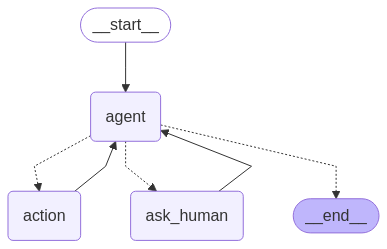

In [7]:
from typing import Literal
from pydantic import BaseModel
from langgraph.graph import MessagesState, START, END, StateGraph
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.types import Command, interrupt
from IPython.display import Image, display

@tool
def search(query: str):
    """Call to surf the web."""
    return f"I looked up: {query}. Result: It's sunny in San Francisco."

# We can define a tool definition for `ask_human`
class AskHuman(BaseModel):
    """Ask the human a question"""
    question: str

tools = [search, AskHuman]
tool_node = ToolNode([search])

# Set up the model
from langchain.chat_models import init_chat_model
llm = init_chat_model("openai:gpt-4o", temperature=0.0)
llm_with_tools = llm.bind_tools(tools)

# Define the function that determines whether to continue or not
def should_continue(state) -> Literal["ask_human", "action", END]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return END
    # If tool call is asking Human, we return that node
    elif last_message.tool_calls[0]["name"] == "AskHuman":
        return "ask_human"
    # Otherwise if there is, we continue
    else:
        return "action"

def call_model(state):
    messages = state["messages"]
    message = llm_with_tools.invoke(messages)
    return {"messages": [message]}

def ask_human(state):
    # Get the tool call ID 
    tool_call_id = state["messages"][-1].tool_calls[0]["id"]
    # Get the AskHuman schema
    ask = AskHuman.model_validate(state["messages"][-1].tool_calls[0]["args"])
    # Interrupt the graph with the question from the AskHuman schema
    location = interrupt(ask.question)
    # Create a tool message once the user has responded with the location
    tool_message = [{"tool_call_id": tool_call_id, "type": "tool", "content": location}]
    return {"messages": tool_message}

# Define a new graph
workflow = StateGraph(MessagesState)
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)
workflow.add_node("ask_human", ask_human)

# Set the entrypoint as `agent`
workflow.add_edge(START, "agent")
# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)
# We now add a normal edge from `tools` to `agent`.
workflow.add_edge("action", "agent")
workflow.add_edge("ask_human", "agent")

# Set up memory
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
# Compile the workflow
app = workflow.compile(checkpointer=memory)
# Draw the graph
display(Image(app.get_graph().draw_mermaid_png()))

Now, we ask the user where they are and look up the weather there:

In [8]:
config = {"configurable": {"thread_id": "1"}}
messages = [{"role": "user", "content": "Ask the user where they are, then look up the weather there"}]
for event in app.stream({"messages": messages}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Ask the user where they are, then look up the weather there
================================== Ai Message ==================================
Tool Calls:
  AskHuman (call_OOV1CwP5496pcNAQb9ONZnw1)
 Call ID: call_OOV1CwP5496pcNAQb9ONZnw1
  Args:
    question: Where are you located?


You can see that our graph got interrupted inside the `ask_human` node. It is now waiting for a location to be provided. You also notice that we use the [checkpointer](https://langchain-ai.github.io/langgraph/concepts/memory/#short-term-memory) to persist the state of the graph after the interrupt. This allows us to resume execution from the same state after the human has responded.

In [9]:
app.get_state(config).next

('ask_human',)

### Using Command to Resume Execution

After an interrupt, we need a way to continue execution. This is where the `Command` interface comes in. [The `Command` object has several powerful capabilities](https://langchain-ai.github.io/langgraph/how-tos/command/):
- `resume`: Provides the value to return from the interrupt call
- `goto`: Specifies which node to route to next
- `update`: Modifies the state before continuing execution
- `graph`: Controls navigation between parent and child graphs

In this case, the `Command` object serves two crucial purposes:
1. It provides the value to be returned from the `interrupt` call
2. It controls the flow of execution in the graph

In [10]:
# Resume execution with the value "san francisco"
for event in app.stream(Command(resume="san francisco"), config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  AskHuman (call_OOV1CwP5496pcNAQb9ONZnw1)
 Call ID: call_OOV1CwP5496pcNAQb9ONZnw1
  Args:
    question: Where are you located?
================================= Tool Message =================================

san francisco
================================== Ai Message ==================================
Tool Calls:
  search (call_GXdoPXRsDP4PAiyxOBa3W46n)
 Call ID: call_GXdoPXRsDP4PAiyxOBa3W46n
  Args:
    query: San Francisco weather
================================= Tool Message =================================
Name: search

I looked up: San Francisco weather. Result: It's sunny in San Francisco.
================================== Ai Message ==================================

The weather in San Francisco is currently sunny.


## Agent Inbox

While we can implement basic human-in-the-loop functionality using `interrupt` calls and `Command` responses with the SDK, as shown above, this doesn't really scale well if we want to process a large number of emails and a variety of different actions. Our email assistant requires several types of human-in-the-loop interactions:

1. **Email Triage Review**:
   - When an email is classified as "NOTIFY," humans should verify this classification
   - Users should be able to accept the classification or provide feedback on how it should be classified

2. **Email Response Review**:
   - Before sending responses to important emails, humans should review the content
   - Users need options to edit the draft, accept it as-is, provide feedback, or reject it entirely

3. **Meeting Scheduling Review**:
   - When the assistant proposes scheduling a meeting, humans should verify the details
   - Users should be able to modify attendees, duration, date/time before accepting

In general, any significant action (sending emails, scheduling meetings) requires human approval. Some low-risk tools (like calendar availability checks) can run without interruption. Of course, this is entirely dependent on the application and the risk of the action.

### Agent Inbox: A Purpose-Built HITL Interface

With this in mind, we built a simple interface for human-in-the-loop called [Agent Inbox](https://github.com/langchain-ai/agent-inbox) that allows us to review and approve or reject actions taken by LangGraph agents. Agent Inbox provides:

1. **Structured Interaction Types**:
   - `accept`: Approve the agent's action and continue
   - `edit`: Modify the agent's proposed action before execution
   - `response`: Provide feedback or answers without editing
   - `ignore`: Reject the agent's action entirely

2. **Rich Content Display**:
   - Render (email) content in a readable format
   - Support markdown for structured information presentation

3. **Consistent User Experience**:
   - Notification system for pending reviews
   - Action buttons that match the allowed interaction types
   - Thread-based organization of agent activities

4. **Easy Integration with LangGraph**:
   - Simple connection to local or hosted LangGraph deployments
   - Compatible with LangGraph's interrupt mechanism
   - No complex frontend development required

### Integration with LangGraph's interrupt() Function

Agent Inbox integrates seamlessly with LangGraph's `interrupt()` function. The integration works like this:

1. **Request Structure**: We structure an interrupt request with specific fields:
   ```python
   request = {
       "action_request": {
           "action": "write_email",  # Name of the tool to call
           "args": {"to": "john@example.com", "subject": "Meeting", "content": "..."}  # Action parameters
       },
       "config": {
           "allow_ignore": True,   # Can dismiss the action
           "allow_respond": True,  # Can provide feedback
           "allow_edit": True,     # Can modify the action
           "allow_accept": True,   # Can approve the action
       },
       "description": "Email content to display..." # Context shown to the user
   }
   ```

2. **Passing to interrupt()**: We pass this request to the interrupt function:
   ```python
   response = interrupt([request])[0]  # Can batch multiple requests
   ```

3. **User Interaction**: Agent Inbox shows the request and collects the user's response

4. **Handling Responses**: When execution resumes, we receive a structured `response`:
   ```python
   if response["type"] == "accept":
       # Execute the tool with original args
   elif response["type"] == "edit":
       # Execute with edited args from response["args"]
   elif response["type"] == "ignore":
       # Skip execution
   elif response["type"] == "response":
       # Process feedback from response["args"]
   ```

This structured approach allows our email assistant to collect precise human input at critical decision points while maintaining a consistent user experience.

## Email Assistant with Human-in-the-Loop

Now that we understand both the interrupt mechanism and Agent Inbox, let's look at our email assistant implementation with human-in-the-loop. This implementation brings together all the concepts we've discussed:

1. It uses the `interrupt` function to pause execution at key decision points
2. It structures interrupt requests specifically for Agent Inbox
3. It processes different response types from human reviewers
4. It integrates these HITL capabilities into a full email processing workflow

We'll instrument each of these human-in-the-loop capabilities into our email assistant. Then, in the next notebook, we'll add in memory!

![overview-img](img/HITL_flow.png)

In [11]:
%cd ..
%load_ext autoreload
%autoreload 2

from typing import Literal
from datetime import datetime
from pydantic import BaseModel

from langchain.chat_models import init_chat_model
from langchain_core.tools import tool

from langgraph.graph import StateGraph, START, END
from langgraph.types import interrupt, Command

from email_assistant.prompts import triage_system_prompt, triage_user_prompt, agent_system_prompt_hitl, default_background, default_triage_instructions, default_response_preferences, default_cal_preferences
from src.email_assistant.tools.default.prompt_templates import STANDARD_TOOLS_PROMPT
from email_assistant.schemas import State, RouterSchema, StateInput
from email_assistant.utils import parse_email, format_for_display, format_email_markdown

# Agent tools 
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

@tool
def schedule_meeting(
    attendees: list[str], subject: str, duration_minutes: int, preferred_day: datetime, start_time: int
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    date_str = preferred_day.strftime("%A, %B %d, %Y")
    return f"Meeting '{subject}' scheduled on {date_str} at {start_time} for {duration_minutes} minutes with {len(attendees)} attendees"

@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

@tool
class Question(BaseModel):
      """Question to ask user."""
      content: str
    
@tool
class Done(BaseModel):
      """E-mail has been sent."""
      done: bool

# All tools available to the agent
tools = [
    write_email, 
    schedule_meeting, 
    check_calendar_availability, 
    Question, 
    Done,
]

tools_by_name = {tool.name: tool for tool in tools}

# Initialize the LLM for use with router / structured output
llm = init_chat_model("openai:gpt-4o", temperature=0.0)
llm_router = llm.with_structured_output(RouterSchema) 

# Initialize the LLM, enforcing tool use (of any available tools) for agent
llm = init_chat_model("openai:gpt-4o", temperature=0.0)
llm_with_tools = llm.bind_tools(tools, tool_choice="required")

/Users/rlm/Desktop/Code
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Nodes of the Email Assistant

Our email assistant has several key nodes that handle different aspects of the workflow:

1. **triage_router**: This node is responsible for analyzing incoming emails and classifying them into three categories:
   - **RESPOND**: Emails that require a response from the assistant.
   - **NOTIFY**: Important emails that don't need a response but should be brought to the user's attention.
   - **IGNORE**: Low-priority emails that can be safely ignored.
   
   The router uses a structured output LLM to make this classification and then routes to the appropriate next node based on its decision.

2. **triage_interrupt_handler**: When an email is classified as "notify," this handler creates an interrupt to display the email in Agent Inbox and collect human feedback. This allows users to:
   - Confirm the notification classification
   - Provide feedback on how they would prefer similar emails to be classified in the future
   
   This feedback loop is crucial for improving the assistant's classification over time.

3. **llm_call**: This node invokes the LLM with the available tools to decide how to respond to an email. The LLM might decide to:
   - Draft a response email
   - Schedule a meeting
   - Ask the user a question
   - Or mark the email as done

Each of these nodes plays a specific role in the overall email processing workflow.

In [8]:
# Nodes 
def triage_router(state: State) -> Command[Literal["triage_interrupt_handler", "response_agent", "__end__"]]:
    """Analyze email content to decide if we should respond, notify, or ignore.

    The triage step prevents the assistant from wasting time on:
    - Marketing emails and spam
    - Company-wide announcements
    - Messages meant for other teams
    """

    # Parse the email input
    author, to, subject, email_thread = parse_email(state["email_input"])
    user_prompt = triage_user_prompt.format(
        author=author, to=to, subject=subject, email_thread=email_thread
    )

    # Create email markdown for Agent Inbox in case of notification  
    email_markdown = format_email_markdown(subject, author, to, email_thread)

    # Format system prompt with background and triage instructions
    system_prompt = triage_system_prompt.format(
        background=default_background,
        triage_instructions=default_triage_instructions
    )

    # Run the router LLM
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )

    # Decision
    classification = result.classification

    # Process the classification decision
    if classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        # Next node
        goto = "response_agent"
        # Update the state
        update = {
            "classification_decision": result.classification,
            "messages": [{"role": "user",
                            "content": f"Respond to the email: {email_markdown}"
                        }],
        }
    elif classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")

        # Next node
        goto = END
        # Update the state
        update = {
            "classification_decision": classification,
        }

    elif classification == "notify":
        print("🔔 Classification: NOTIFY - This email contains important information") 

        # Next node
        goto = "triage_interrupt_handler"
        # Update the state
        update = {
            "classification_decision": classification,
        }

    else:
        raise ValueError(f"Invalid classification: {classification}")
    return Command(goto=goto, update=update)

def triage_interrupt_handler(state: State) -> Command[Literal["response_agent", "__end__"]]:
    """Handles interrupts from the triage step"""
    
    # Parse the email input
    author, to, subject, email_thread = parse_email(state["email_input"])

    # Create email markdown for Agent Inbox in case of notification  
    email_markdown = format_email_markdown(subject, author, to, email_thread)

    # Create messages
    messages = [{"role": "user",
                "content": f"Email to notify user about: {email_markdown}"
                }]

    # Create interrupt for Agent Inbox
    request = {
        "action_request": {
            "action": f"Email Assistant: {state['classification_decision']}",
            "args": {}
        },
        "config": {
            "allow_ignore": True,  
            "allow_respond": True, 
            "allow_edit": False, 
            "allow_accept": False,  
        },
        # Email to show in Agent Inbox
        "description": email_markdown,
    }

    # Agent Inbox responds with a list  
    response = interrupt([request])[0]

    # If user provides feedback, go to response agent and use feedback to respond to email   
    if response["type"] == "response":
        # Add feedback to messages 
        user_input = response["args"]
        # Used by the response agent
        messages.append({"role": "user",
                        "content": f"User wants to reply to the email. Use this feedback to respond: {user_input}"
                        })
        # Go to response agent
        goto = "response_agent"

    # If user ignores email, go to END
    elif response["type"] == "ignore":
        goto = END

    # Catch all other responses
    else:
        raise ValueError(f"Invalid response: {response}")

    # Update the state 
    update = {
        "messages": messages,
    }

    return Command(goto=goto, update=update)

def llm_call(state: State):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    {"role": "system", "content": agent_system_prompt_hitl.format(tools_prompt=STANDARD_TOOLS_PROMPT, 
                                                                                  background=default_background,
                                                                                  response_preferences=default_response_preferences, 
                                                                                  cal_preferences=default_cal_preferences)}
                ]
                + state["messages"]
            )
        ]
    }

### The interrupt_handler

The `interrupt_handler` is the core HITL component of our response agent. Its job is to examine the tool calls that the LLM wants to make and determine which ones need human review before execution. Here's how it works:

1. **Tool Selection**: The handler maintains a list of "HITL tools" that require human approval:
   - `write_email`: Since sending emails has significant external impact
   - `schedule_meeting`: Since scheduling meetings affects calendars
   - `Question`: Since asking users questions requires direct interaction

2. **Direct Execution**: Tools not in the HITL list (like `check_calendar_availability`) are executed immediately without interruption. This allows low-risk operations to proceed automatically.

3. **Context Preparation**: For tools requiring review, the handler:
   - Retrieves the original email for context
   - Formats the tool call details for clear display
   - Configures which interaction types are allowed for each tool type

4. **Interrupt Creation**: The handler creates a structured interrupt request with:
   - The action name and arguments
   - Configuration for allowed interaction types
   - A description that includes both the original email and the proposed action

5. **Response Processing**: After the interrupt, the handler processes the human response:
   - **Accept**: Executes the tool with original arguments
   - **Edit**: Updates the tool call with edited arguments and then executes
   - **Ignore**: Cancels the tool execution
   - **Response**: Records feedback without execution

This handler ensures humans have oversight of all significant actions while allowing routine operations to proceed automatically. The ability to edit tool arguments (like email content or meeting details) gives users precise control over the assistant's actions.

In [9]:
def interrupt_handler(state: State) -> Command[Literal["llm_call", "__end__"]]:
    """Creates an interrupt for human review of tool calls"""
    
    # Store messages
    result = []

    # Go to the LLM call node next
    goto = "llm_call"

    # Iterate over the tool calls in the last message
    for tool_call in state["messages"][-1].tool_calls:
        
        # Allowed tools for HITL
        hitl_tools = ["write_email", "schedule_meeting", "Question"]
        
        # If tool is not in our HITL list, execute it directly without interruption
        if tool_call["name"] not in hitl_tools:

            # Execute search_memory and other tools without interruption
            tool = tools_by_name[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
            continue
            
        # Get original email from email_input in state
        email_input = state["email_input"]
        author, to, subject, email_thread = parse_email(email_input)
        original_email_markdown = format_email_markdown(subject, author, to, email_thread)
        
        # Format tool call for display and prepend the original email
        tool_display = format_for_display(state, tool_call)
        description = original_email_markdown + tool_display

        # Configure what actions are allowed in Agent Inbox
        if tool_call["name"] == "write_email":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": True,
                "allow_accept": True,
            }
        elif tool_call["name"] == "schedule_meeting":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": True,
                "allow_accept": True,
            }
        elif tool_call["name"] == "Question":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": False,
                "allow_accept": False,
            }
        else:
            raise ValueError(f"Invalid tool call: {tool_call['name']}")

        # Create the interrupt request
        request = {
            "action_request": {
                "action": tool_call["name"],
                "args": tool_call["args"]
            },
            "config": config,
            "description": description,
        }

        # Send to Agent Inbox and wait for response
        response = interrupt([request])[0]

        # Handle the responses 
        if response["type"] == "accept":

            # Execute the tool with original args
            tool = tools_by_name[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
                        
        elif response["type"] == "edit":

            # Tool selection 
            tool = tools_by_name[tool_call["name"]]
            
            # Get edited args from Agent Inbox
            edited_args = response["args"]["args"]

            # Update the write_email tool call with the edited content from Agent Inbox
            if tool_call["name"] == "write_email":
                
                # Update the AI message's tool call with edited content (reference to the message in the state)
                ai_message = state["messages"][-1]
                current_id = tool_call["id"]
                
                # Replace the original tool call with the edited one (any changes made to this reference affect the original object in the state)
                ai_message.tool_calls = [tc for tc in ai_message.tool_calls if tc["id"] != current_id] + [
                    {"type": "tool_call", "name": tool_call["name"], "args": edited_args, "id": current_id}
                ]
                
                # Execute the tool with edited args
                observation = tool.invoke(edited_args)
                
                # Add only the tool response message
                result.append({"role": "tool", "content": observation, "tool_call_id": current_id})
            
            # Update the schedule_meeting tool call with the edited content from Agent Inbox
            elif tool_call["name"] == "schedule_meeting":
                
                # Update the AI message's tool call with edited content
                ai_message = state["messages"][-1]
                current_id = tool_call["id"]
                
                # Replace the original tool call with the edited one
                ai_message.tool_calls = [tc for tc in ai_message.tool_calls if tc["id"] != current_id] + [
                    {"type": "tool_call", "name": tool_call["name"], "args": edited_args, "id": current_id}
                ]
                
                # Execute the tool with edited args
                observation = tool.invoke(edited_args)
                
                # Add only the tool response message
                result.append({"role": "tool", "content": observation, "tool_call_id": current_id})
            
            # Catch all other tool calls
            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

        elif response["type"] == "ignore":
            if tool_call["name"] == "write_email":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this email draft. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
            elif tool_call["name"] == "schedule_meeting":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this calendar meeting draft. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
            elif tool_call["name"] == "Question":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this question. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")
            
        elif response["type"] == "response":
            # User provided feedback
            user_feedback = response["args"]
            if tool_call["name"] == "write_email":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User gave feedback, which can we incorporate into the email. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
            elif tool_call["name"] == "schedule_meeting":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User gave feedback, which can we incorporate into the meeting request. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
            elif tool_call["name"] == "Question":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User answered the question, which can we can use for any follow up actions. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

        # Catch all other responses
        else:
            raise ValueError(f"Invalid response: {response}")
            
    # Update the state 
    update = {
        "messages": result,
    }

    return Command(goto=goto, update=update)

### HITL Email Assistant Workflow

Now we can integrate everything into a complete workflow that connects all the components. The workflow consists of two main parts:

1. **Response Agent Subgraph**:
   First, we build a standalone agent that can handle email responses:
   - The `llm_call` node generates responses or tool calls
   - The `should_continue` function checks if the agent is done or needs to use a tool
   - The `interrupt_handler` manages human review of tool execution
   - The cycle continues until the agent reaches a conclusion
   
   This response agent is compiled as a reusable subgraph.

2. **Overall Email Assistant Workflow**:
   Then, we create the main workflow that:
   - Starts with `triage_router` to classify the email
   - Routes to `triage_interrupt_handler` for NOTIFY classifications
   - Routes to `response_agent` for RESPOND classifications
   - Ends immediately for IGNORE classifications

This architecture provides a clean separation of concerns, with distinct components for triage, response generation, and human oversight. The resulting workflow gives us a complete email assistant that:

- Analyzes incoming emails
- Correctly routes them based on importance
- Engages humans for oversight at critical decision points
- Responds appropriately to important emails

The final graph visualization shows the complete flow from email input through triage and, when necessary, through the response generation process with human oversight at each significant step.

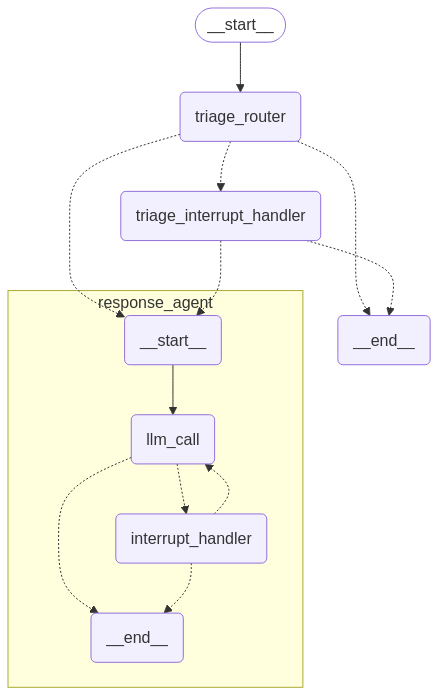

In [10]:
# Conditional edge function
def should_continue(state: State) -> Literal["interrupt_handler", END]:
    """Route to tool handler, or end if Done tool called"""
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        for tool_call in last_message.tool_calls: 
            if tool_call["name"] == "Done":
                return END
            else:
                return "interrupt_handler"

# Build workflow
agent_builder = StateGraph(State)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("interrupt_handler", interrupt_handler)

# Add edges
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "interrupt_handler": "interrupt_handler",
        END: END,
    },
)

# Compile the agent
response_agent = agent_builder.compile()

# Build overall workflow
overall_workflow = (
    StateGraph(State, input=StateInput)
    .add_node(triage_router)
    .add_node(triage_interrupt_handler)
    .add_node("response_agent", response_agent)
    .add_edge(START, "triage_router")
    
)

email_assistant = overall_workflow.compile()
display(Image(email_assistant.get_graph(xray=True).draw_mermaid_png()))

Now, we can test the workflow! 

## Accept `write_email` and `schedule_meeting`

This test demonstrates the fundamental HITL approval flow when a user accepts all agent actions:
1. An email about tax planning is received and classified as "RESPOND"
2. The agent checks calendar availability for both suggested dates (Tuesday and Thursday)
3. The agent proposes scheduling a meeting on Tuesday at 2:00 PM for 45 minutes
4. The user reviews and ACCEPTS the meeting request without changes
5. The agent drafts a confirmation email to send to the client
6. The user reviews and ACCEPTS the email draft without changes
7. The agent marks the workflow as complete

This scenario shows how human-in-the-loop works at its most basic level - humans provide oversight while the agent handles the execution.

In [11]:
import uuid

# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph
checkpointer = MemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_1 = uuid.uuid4()
thread_config_1 = {"configurable": {"thread_id": thread_id_1}}

# Run the graph until the first interrupt 
# Email will be classified as "respond" 
# Agent will create a schedule_meeting and write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-04-22', 'start_time': 14}}


Accept the `schedule_meeting` tool call

After the agent proposes scheduling a meeting, it creates an interrupt to seek human approval. In this step, we simulate a user accepting the proposed meeting parameters without changes. This allows the workflow to proceed to the next step (drafting a confirmation email). The interrupt object contains critical information:

1. The action type (`schedule_meeting`)
2. The proposed meeting parameters (attendees, subject, duration, day, time)
3. Configuration options for what kinds of responses are allowed

When the user accepts, the tool is executed as proposed without modification.

In [12]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-04-22', 'start_time': 14}} tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hello,\n\nThank you for reaching out. I have scheduled a call for us to discuss tax planning strategies on Tuesday, April 22, 2025, at 2:00 PM. The meeting is set for 45 minutes.\n\nLooking forward to our discussion.\n\nBest regards,\n\nLance Martin'}}


Accept the `write_email` tool call

With the meeting scheduled, the agent now drafts a confirmation email to the client. The interrupt contains:

1. The email tool action with recipient, subject, and proposed content
2. The formatted email showing what will be sent
3. The same configuration options for user response types

When the user accepts, the email is sent as written. After this step, the agent marks the task as complete with the `Done` tool call, and the workflow ends. The complete message history shows all the steps taken:

1. Initial email processing
2. Calendar availability checks for both days
3. Meeting scheduling with confirmation
4. Email composition and sending
5. Workflow completion

In [13]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_1):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hello,\n\nThank you for reaching out. I have scheduled a call for us to discuss tax planning strategies on Tuesday, April 22, 2025, at 2:00 PM. The meeting is set for 45 minutes.\n\nLooking forward to our discussion.\n\nBest regards,\n\nLance Martin'}} tool call...
================================== Ai Message ==================================
Tool Calls:
  Done (call_h6a55b78txHk7GV7yQa9sQU9)
 Call ID: call_h6a55b78txHk7GV7yQa9sQU9
  Args:
    done: True


Look at the full message history, and see trace:

https://smith.langchain.com/public/82277f96-3abd-48e0-a4db-413f7572240d/r

In [14]:
state = graph.get_state(thread_config_1)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Lance Martin <lance@company.com>

Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_NrkaML1VPyeDXFNiQZUvfGIo)
 Call ID: call_NrkaML1VPyeDXFNiQZUvfGIo
  Args:
    day: 2025-04-22
  check_calendar_availability (call_cjRWdZCRnPsYsagEGZxASZht)
 Call ID: call_cjRWdZCRnPsYsagEGZxASZht
  Args:
    day: 2025-04-24
================================= Tool Message =================================

Ava

## Edit `write_email` and `schedule_meeting`

This test demonstrates how human modification works in the HITL flow:
1. We start with the same tax planning email as before
2. The agent proposes a meeting with the same parameters
3. This time, the user EDITS the meeting proposal to change:
   - Duration from 45 to 30 minutes
   - Meeting subject is made more concise
4. The agent adapts to these changes when drafting the email
5. The user further EDITS the email to be shorter and less formal
6. The workflow completes with both modifications incorporated

This scenario showcases one of the most powerful aspects of HITL: users can make precise modifications to agent actions before they are executed, ensuring the final outcome matches their preferences without having to handle all the details themselves.

In [15]:
# Same email as before
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph with new thread
checkpointer = MemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_2 = uuid.uuid4()
thread_config_2 = {"configurable": {"thread_id": thread_id_2}}

# Run the graph until the first interrupt - will be classified as "respond" and the agent will create a write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_2):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-04-22', 'start_time': 14}}


Edit the `schedule_meeting` tool call

When the agent proposes the initial meeting schedule, we now simulate the user making modifications through the edit functionality. This demonstrates how the `edit` response type works:

1. The user receives the same meeting proposal as in the previous test
2. Instead of accepting, they modify the parameters:
   - Reducing duration from 45 to 30 minutes
   - Keeping the same day and time
3. The `edit` response includes the complete set of modified arguments
4. The interrupt handler replaces the original tool arguments with these edited ones
5. The tool is executed with the user's modifications

This shows how edit capability gives users precise control over agent actions while still letting the agent handle the execution details.

In [17]:
# Now simulate user editing the schedule_meeting tool call
print("\nSimulating user editing the schedule_meeting tool call...")
edited_schedule_args = {
    "attendees": ["pm@client.com", "lance@company.com"],
    "subject": "Tax Planning Discussion",
    "duration_minutes": 30,  # Changed from 45 to 30
    "preferred_day": "2025-04-22",
    "start_time": 14 
}
for chunk in graph.stream(Command(resume=[{"type": "edit", "args": {"args": edited_schedule_args}}]), config=thread_config_2):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user editing the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hi,\n\nThank you for reaching out. I have scheduled a call for us to discuss tax planning strategies on Tuesday, April 22, 2025, at 2:00 PM. We will have 30 minutes to go over your suggestions.\n\nLooking forward to our discussion.\n\nBest regards,\n\nLance Martin'}}


Edit the `write_email` tool call

After accepting the modified meeting schedule, the agent drafts an email reflecting the 30-minute duration. Now we demonstrate how editing works with email content:

1. The agent has adapted its email to mention the shorter 30-minute duration
2. We simulate the user wanting an even more significant change to the email:
   - Completely rewriting the content to be shorter and less formal
   - Changing the meeting day mentioned in the email (showing how users can correct agent mistakes)
   - Requesting confirmation rather than stating the meeting as definite
3. The `edit` response contains the complete new email content
4. The tool arguments are updated with this edited content
5. The email is sent with the user's preferred wording

This example shows the power of HITL for complex communication tasks - the agent handles the structure and initial content, while humans can refine tone, style, and substance.

In [18]:
# Now simulate user editing the write_email tool call
print("\nSimulating user editing the write_email tool call...")
edited_email_args = {
    "to": "pm@client.com",
    "subject": "Re: Tax season let's schedule call",
    "content": "Hello Project Manager,\n\nThank you for reaching out about tax planning. I scheduled a 30-minute call next Thursday at 3:00 PM. Would that work for you?\n\nBest regards,\nLance Martin"
}
for chunk in graph.stream(Command(resume=[{"type": "edit", "args": {"args": edited_email_args}}]), config=thread_config_2):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user editing the write_email tool call...
================================== Ai Message ==================================
Tool Calls:
  Done (call_S8jqCkQbJCK4EarhsRS9vdpj)
 Call ID: call_S8jqCkQbJCK4EarhsRS9vdpj
  Args:
    done: True


Look at the full message history, and see trace, to view the edited tool calls:

https://smith.langchain.com/public/21769510-d57a-41e4-b5c7-0ddb23c237d8/r

In [19]:
state = graph.get_state(thread_config_2)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Lance Martin <lance@company.com>

Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_jmfLrZBnaHDZ4Y2VCoiMYdzC)
 Call ID: call_jmfLrZBnaHDZ4Y2VCoiMYdzC
  Args:
    day: 2025-04-22
================================= Tool Message =================================

Available times on 2025-04-22: 9:00 AM, 2:00 PM, 4:00 PM
================================== Ai Message ==============================

## Ignore `write_email`, `schedule_meeting`, and `question`

This test set demonstrates the "ignore" capability of the HITL system, showing how users can reject agent actions entirely:

1. First, we test ignoring a `schedule_meeting` request:
   - When the agent proposes scheduling a meeting, the user rejects it completely
   - The workflow ends immediately without scheduling anything
   
2. Second, we test accepting a meeting but ignoring the follow-up email:
   - The user accepts the meeting schedule
   - But when the agent drafts a confirmation email, the user ignores it
   - The meeting is still scheduled, but no email is sent
   - The workflow ends after the rejection

3. Third, we test ignoring a `question` tool call:
   - For a different email about brunch plans
   - The agent asks a clarifying question
   - The user ignores the question
   - The workflow ends without further action

The "ignore" capability is crucial for HITL systems as it allows users to stop potentially unwanted actions before they occur, providing an important safety mechanism and ensuring users maintain full control.

In [20]:
# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph
checkpointer = MemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_3 = uuid.uuid4()
thread_config_3 = {"configurable": {"thread_id": thread_id_3}}

# Run the graph until the first interrupt 
# Email will be classified as "respond" 
# Agent will create a schedule_meeting and write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_3):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-04-22', 'start_time': 14}}


Ignore the `schedule_meeting` tool call

In this test, we demonstrate rejection of the meeting scheduling proposal:

1. The agent suggests a 45-minute meeting on Tuesday at 2:00 PM
2. We simulate the user selecting "ignore" in the Agent Inbox interface
3. The `interrupt_handler` processes this rejection with special logic:
   - It adds a message explaining the user's choice to ignore
   - It returns a command to end the workflow
   - No meeting is scheduled and no email is sent

This capability is crucial for several reasons:
- Prevents incorrect actions from being executed
- Gives users veto power over any agent decision
- Provides a clear exit path when the agent's suggestion isn't appropriate

The trace shows how the workflow ends immediately after the ignore action.

In [21]:
print(f"\nSimulating user ignoring the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "ignore"}]), config=thread_config_3):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user ignoring the {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-04-22', 'start_time': 14}} tool call...


As you can see from the trace, we end:

https://smith.langchain.com/public/4e322b99-08ea-4d23-9653-475415ff3e33/r

Now, let's run again, but ignore the `write_email` tool call:

In [22]:
# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph
checkpointer = MemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_3 = uuid.uuid4()
thread_config_3 = {"configurable": {"thread_id": thread_id_3}}

# Run the graph until the first interrupt 
# Email will be classified as "respond" 
# Agent will create a schedule_meeting and write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_3):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_3):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

print(f"\nSimulating user ignoring the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "ignore"}]), config=thread_config_3):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-04-22', 'start_time': 14}}

Simulating user accepting the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hi,\n\nThank you for reaching out. I have scheduled our call to discuss tax planning strategies for Tuesday, April 22, 2025, at 2:00 PM. We will have 45 minutes to go over your suggestions.\n\nLooking forward to our discussion.\n\nBest regards,\n\nLance Martin'}}

Simulating user ignoring the write_email tool call...
================================= Tool Message =================================

User ignored this email dra

Again, we end:

https://smith.langchain.com/public/819be555-4919-4d14-bdd9-eb6f73a3bafe/r

In [23]:
state = graph.get_state(thread_config_3)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Lance Martin <lance@company.com>

Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_JpQevSvNkmodiACKRfONrqan)
 Call ID: call_JpQevSvNkmodiACKRfONrqan
  Args:
    day: 2025-04-22
  check_calendar_availability (call_3gJfzFvJkgY9lRVTpUF1D9Zt)
 Call ID: call_3gJfzFvJkgY9lRVTpUF1D9Zt
  Args:
    day: 2025-04-24
================================= Tool Message =================================

Ava

Now let's try an email that calls the `Question` tool

The `Question` tool represents another important HITL interaction pattern - the agent asking for additional information rather than taking immediate action. This test shows:

1. A different email scenario about a potential brunch invitation
2. The agent doesn't have enough information to respond definitively
3. Instead of guessing, it uses the `Question` tool to ask for clarification
4. We'll simulate the user ignoring this question

This demonstrates how the HITL system gracefully handles requests for information, and what happens when users choose not to engage with these requests.

In [24]:
# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Partner <partner@home.com>",
    "subject": "Meet Jim and Lisa for brunch in 3 weeks?",
    "email_thread": "Hey, should we invite Jim and Lisa to brunch in 3 weeks? We could go to the new place on 17th that everyone is talking about."
}

# Compile the graph
checkpointer = MemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_4 = uuid.uuid4()
thread_config_4 = {"configurable": {"thread_id": thread_id_4}}

# Run the graph until the first interrupt 
# Email will be classified as "respond" 
# Agent will create a schedule_meeting and write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_4):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'Question', 'args': {'content': 'What day and time are you considering for the brunch in 3 weeks?'}}


Ignore the `question` tool call

When the agent asks for clarification about the brunch plans, we simulate a user ignoring the question:

1. The agent has asked about preferred day and time for the brunch
2. We provide an "ignore" response to this question
3. The system processes this as a decision to abandon handling this email:
   - A message is added stating "User ignored this question. Ignore this email and end the workflow."
   - The workflow ends without sending any response

This pattern is important because it allows users to:
- Decide that some emails don't actually need responses
- Avoid providing information they're not ready to share
- Defer decision-making to a later time
- Take over email handling manually if they prefer

The trace and message history show how cleanly the workflow ends after ignoring the question.

In [25]:
print(f"\nSimulating user ignoring the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "ignore"}]), config=thread_config_4):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user ignoring the {'action': 'Question', 'args': {'content': 'What day and time are you considering for the brunch in 3 weeks?'}} tool call...


As before, we end:

https://smith.langchain.com/public/276c4016-2b4c-43f5-a677-834a5eaa47c0/r

In [26]:
state = graph.get_state(thread_config_4)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Meet Jim and Lisa for brunch in 3 weeks?
**From**: Partner <partner@home.com>
**To**: Lance Martin <lance@company.com>

Hey, should we invite Jim and Lisa to brunch in 3 weeks? We could go to the new place on 17th that everyone is talking about.

---

================================== Ai Message ==================================
Tool Calls:
  Question (call_l6LC1srm8qt8CJCihDTz7wAW)
 Call ID: call_l6LC1srm8qt8CJCihDTz7wAW
  Args:
    content: What day and time are you considering for the brunch in 3 weeks?
================================= Tool Message =================================

User ignored this question. Ignore this email and end the workflow.


## Respond (with feedback) `write_email`, `schedule_meeting`, and `question`

This test set demonstrates the "response" capability - providing feedback without editing or accepting:

1. First, we test feedback for meeting scheduling:
   - The user provides specific preferences (30 minutes instead of 45, and afternoon meetings)
   - The agent incorporates this feedback into a revised proposal
   - The user then accepts the revised meeting schedule

2. Second, we test feedback for email drafting:
   - The user requests a shorter, less formal email with a specific closing statement
   - The agent completely rewrites the email according to this guidance
   - The user accepts the new draft

3. Lastly, we test feedback for questions:
   - For the brunch invitation, the user answers the question with additional context
   - The agent uses this information to draft an appropriate email response
   - The workflow proceeds with the user's input integrated

The "response" capability bridges the gap between acceptance and editing - users can guide the agent without having to write the full content themselves. This is especially powerful for:
- Adjusting tone and style
- Adding context the agent missed
- Redirecting the agent's approach
- Answering questions in a way that shapes the next steps

In [27]:
# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph
checkpointer = MemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_5 = uuid.uuid4()
thread_config_5 = {"configurable": {"thread_id": thread_id_5}}

# Run the graph until the first interrupt 
# Email will be classified as "respond" 
# Agent will create a schedule_meeting and write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-04-22', 'start_time': 14}}


Provide feedback for the `schedule_meeting` tool call

Now we explore the feedback capability for meeting scheduling:

1. The agent proposes the standard 45-minute meeting on Tuesday at 2:00 PM
2. Instead of accepting or editing, we provide feedback in natural language
3. Our feedback specifies two preferences:
   - Shorter meeting (30 minutes instead of 45)
   - Preference for afternoon meetings (after 2pm)
4. The agent receives this feedback through the `response` type
5. The interrupt handler adds this feedback as a message to the state
6. The agent processes this feedback and generates a new tool call incorporating these preferences

Unlike direct editing, which requires specifying the entire set of parameters, feedback allows users to express their preferences conversationally. The agent must then interpret this feedback and apply it appropriately to create a revised proposal.

In [28]:
print(f"\nSimulating user providing feedback for the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "Please schedule this for 30 minutes instead of 45 minutes, and I prefer afternoon meetings after 2pm."}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user providing feedback for the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 30, 'preferred_day': '2025-04-22', 'start_time': 14}}


Accept the `schedule_meeting` tool call after providing feedback

In [29]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 30, 'preferred_day': '2025-04-22', 'start_time': 14}} tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': "Hello,\n\nThank you for reaching out. I've scheduled a call for us to discuss tax planning strategies on Tuesday, April 22, 2025, at 2:00 PM. The meeting is set for 30 minutes.\n\nLooking forward to our discussion.\n\nBest regards,\n\nLance Martin"}}


Now provide feedback for the `write_email` tool call

After accepting the revised meeting schedule, the agent drafts an email. We now test feedback for email content:

1. The agent's email is relatively formal and detailed
2. We provide stylistic feedback requesting:
   - A shorter, more concise email
   - A less formal tone
   - A specific closing statement about looking forward to the meeting
3. The agent processes this feedback to completely rewrite the email
4. The new draft is much shorter, more casual, and includes the requested closing

This demonstrates the power of natural language feedback for content creation:
- Users don't need to rewrite the entire email themselves
- They can provide high-level guidance on style, tone, and content
- The agent handles the actual writing based on this guidance
- The result better matches user preferences while preserving the essential information

The message history shows both the original and revised emails, clearly showing how the feedback was incorporated.

In [30]:
print(f"\nSimulating user providing feedback for the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "Shorter and less formal. Include a closing statement about looking forward to the meeting!"}]), config=thread_config_5):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user providing feedback for the write_email tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': "Hi,\n\nI've set up our call for Tuesday, April 22, at 2:00 PM for 30 minutes. Looking forward to it!\n\nBest,\nLance"}}


Accept the `write_email` tool call after providing feedback

In [31]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': "Hi,\n\nI've set up our call for Tuesday, April 22, at 2:00 PM for 30 minutes. Looking forward to it!\n\nBest,\nLance"}} tool call...


Look at the full message history, and see the trace:

https://smith.langchain.com/public/57006770-6bb3-4e40-b990-143c373ebe60/r

We can see that user feedback in incorporated into the tool calls.  

In [32]:
state = graph.get_state(thread_config_5)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Lance Martin <lance@company.com>

Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_5Cs51CxeKicG85x0xeeZgRxg)
 Call ID: call_5Cs51CxeKicG85x0xeeZgRxg
  Args:
    day: 2025-04-22
  check_calendar_availability (call_c7m8uYJaVH9x6l5zJdUj3HMk)
 Call ID: call_c7m8uYJaVH9x6l5zJdUj3HMk
  Args:
    day: 2025-04-24
================================= Tool Message =================================

Ava

Now let's try an email that calls the `Question` tool to provide feedback

Finally, we test how feedback works with the `Question` tool:

1. For the brunch invitation email, the agent asks about preferred day and time
2. Instead of ignoring, we provide a substantive response with additional context:
   - Confirming we want to invite the people mentioned
   - Noting we need to check which weekend works best
   - Adding information about needing a reservation
3. The agent uses this information to:
   - Draft a comprehensive email response incorporating all our feedback
   - Notice we didn't provide a specific day/time, so it suggests checking the calendar
   - Include the detail about making a reservation
4. The complete email reflects both the original request and our additional guidance

This demonstrates how question responses can shape the entire workflow:
- Questions let the agent gather missing information
- User responses can include both direct answers and additional context
- The agent integrates all this information into its next actions
- The final outcome reflects the collaborative intelligence of both human and AI

In [33]:
# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Partner <partner@home.com>",
    "subject": "Meet Jim and Lisa for brunch in 3 weeks?",
    "email_thread": "Hey, should we invite Jim and Lisa to brunch in 3 weeks? We could go to the new place on 17th that everyone is talking about."
}

# Compile the graph
checkpointer = MemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_6 = uuid.uuid4()
thread_config_6 = {"configurable": {"thread_id": thread_id_6}}

# Run the graph until the first interrupt
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_6):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'Question', 'args': {'content': 'What day and time are you considering for the brunch in 3 weeks? I can check my calendar for availability.'}}


Provide feedback for the `Question` tool call

In [34]:
print(f"\nSimulating user providing feedback for the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "Yes, let's invite them, but let me confirm which weekend works best. Also mention that we'll need to make a reservation since that place is popular."}]), config=thread_config_6):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user providing feedback for the Question tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'partner@home.com', 'subject': 'Re: Meet Jim and Lisa for brunch in 3 weeks?', 'content': "Hi,\n\nYes, let's definitely invite Jim and Lisa for brunch. I'll check my calendar to confirm which weekend works best for us. Also, since the new place on 17th is quite popular, we'll need to make a reservation in advance.\n\nI'll get back to you shortly with the best date.\n\nBest,\nLance"}}


Accept the `write_email` tool call

In [35]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_6):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the write_email tool call...
================================== Ai Message ==================================
Tool Calls:
  Done (call_TWXVmN0lmZpypDo7TZwEEWuw)
 Call ID: call_TWXVmN0lmZpypDo7TZwEEWuw
  Args:
    done: True


Look at the full message history, and see the trace:

https://smith.langchain.com/public/f4c727c3-b1d9-47a5-b3d0-3451619db8a2/r

We can see that user feedback in incorporated into the email response.

In [36]:
state = graph.get_state(thread_config_6)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Meet Jim and Lisa for brunch in 3 weeks?
**From**: Partner <partner@home.com>
**To**: Lance Martin <lance@company.com>

Hey, should we invite Jim and Lisa to brunch in 3 weeks? We could go to the new place on 17th that everyone is talking about.

---

================================== Ai Message ==================================
Tool Calls:
  Question (call_ebOvuGZuyzNxziFBrYtXifeJ)
 Call ID: call_ebOvuGZuyzNxziFBrYtXifeJ
  Args:
    content: What day and time are you considering for the brunch in 3 weeks? I can check my calendar for availability.
================================= Tool Message =================================

User answered the question, which can we can use for any follow up actions. Feedback: Yes, let's invite them, but let me confirm which weekend works best. Also mention that we'll need to make a reservation since that place is popular.
========

## Test Case for Notify Classification

This test demonstrates how the system handles emails classified as "NOTIFY" and how users can respond to notifications:

1. The triage system classifies important informational emails as "NOTIFY" when:
   - They contain important information (like security updates)
   - They don't require immediate action
   - They should be brought to the user's attention
   
2. For notify classifications:
   - The workflow routes to the `triage_interrupt_handler`
   - The user sees the email content with options to ignore or respond
   - No default action is suggested

3. In this test, we:
   - Process an IT security update email that gets classified as "NOTIFY"
   - Simulate the user deciding to respond with specific feedback
   - See how the agent drafts an appropriate response based on this feedback
   - Approve the response to be sent

This showcases how the HITL system can transform a passive notification into an active response when the user decides one is warranted, bridging the gap between the initial "NOTIFY" classification and a full response.

In [37]:
# Notify - Important FYI Email
email_input_notify = {
    "to": "Team Members <team@company.com>",
    "author": "IT Department <it@company.com>",
    "subject": "Critical Security Update",
    "email_thread": "Dear Team,\n\nThis is an important security notification. We will be updating our authentication system this weekend. During the update window (Saturday 2am-4am), you will not be able to access company resources.\n\nPlease ensure you log out of all systems before the maintenance window.\n\nRegards,\nIT Department"
}

# Compile the graph with new thread
checkpointer = MemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_7 = uuid.uuid4()
thread_config_7 = {"configurable": {"thread_id": thread_id_7}}

# Run the graph until the first interrupt - should be classified as "notify"
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_notify}, config=thread_config_7):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...
🔔 Classification: NOTIFY - This email contains important information

INTERRUPT OBJECT:
Action Request: {'action': 'Email Assistant: notify', 'args': {}}


Now simulate user deciding to respond with feedback.

Although the email was classified as "NOTIFY" (meaning it normally wouldn't require a response), the HITL system gives users the flexibility to override this classification. In this step:

1. We provide feedback indicating we want to acknowledge receipt of the security notice
2. The `triage_interrupt_handler` processes this feedback:
   - It adds the user's guidance as a message to the state
   - It routes to the `response_agent` node instead of ending
3. The response agent uses this guidance to draft an appropriate acknowledgment email
4. An interrupt is created for the user to review this draft before sending

This demonstrates an important capability: the ability for users to override the initial classification when they feel a response is warranted. This ensures that the system remains flexible and adaptable to user preferences, while still providing useful initial triage.

In [38]:
print("\nSimulating user deciding to respond with feedback...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "We should acknowledge receipt of this important notice and confirm that we'll be logged out before the maintenance window."}]), config=thread_config_7):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user deciding to respond with feedback...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'it@company.com', 'subject': 'Re: Critical Security Update', 'content': 'Dear IT Department,\n\nThank you for the important security update notification. I acknowledge receipt of this notice and confirm that I will ensure to log out of all systems before the maintenance window this Saturday from 2am to 4am.\n\nRegards,\nLance'}}


Accept the `write_email` tool call after feedback.

In [39]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_7):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the {'action': 'write_email', 'args': {'to': 'it@company.com', 'subject': 'Re: Critical Security Update', 'content': 'Dear IT Department,\n\nThank you for the important security update notification. I acknowledge receipt of this notice and confirm that I will ensure to log out of all systems before the maintenance window this Saturday from 2am to 4am.\n\nRegards,\nLance'}} tool call...


Look at the full message history, and see the trace:

https://smith.langchain.com/public/6594f98f-eb83-4560-9c34-28ec22ada3dc/r

We can see that user feedback causes agent to go reply to the email.

In [40]:
state = graph.get_state(thread_config_7)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Email to notify user about: 

**Subject**: Critical Security Update
**From**: IT Department <it@company.com>
**To**: Team Members <team@company.com>

Dear Team,

This is an important security notification. We will be updating our authentication system this weekend. During the update window (Saturday 2am-4am), you will not be able to access company resources.

Please ensure you log out of all systems before the maintenance window.

Regards,
IT Department

---

================================ Human Message =================================

User wants to reply to the email. Use this feedback to respond: We should acknowledge receipt of this important notice and confirm that we'll be logged out before the maintenance window.
================================== Ai Message ==================================
Tool Calls:
  write_email (call_9fi3k78DE98MFtey5aYSaql7)
 Call ID: call_9fi3k78DE98MFtey5aYSaql7
  Args

## Test Case for Notify + Ignore

This test demonstrates the other path for notifications - when users choose to simply acknowledge without responding:

1. We process a company picnic announcement email, which gets classified as "NOTIFY"
2. The user decides this notification needs no response and chooses to ignore it
3. The workflow ends immediately with no further action

This scenario highlights several key aspects of the HITL system:
- The initial triage correctly identifies information that's worth seeing but doesn't require action
- Users can quickly process such notifications with minimal interaction
- The system respects the user's decision not to act
- The workflow efficiently ends without wasting time on unnecessary steps

Together with the previous test, this demonstrates the complete notification handling workflow:
- Some notifications warrant responses (previous test)
- Others simply need acknowledgment (this test)
- The user maintains control over which path to take

In [41]:
# Notify - Important FYI Email
email_input_notify = {
    "to": "Team Members <team@company.com>",
    "author": "HR Department <hr@company.com>",
    "subject": "Company Picnic Next Month",
    "email_thread": "Dear Team,\n\nWe're planning the annual company picnic for next month. The tentative date is Saturday, June 15th from noon to 4pm at Central Park. There will be food, games, and activities for families.\n\nMore details will follow in the coming weeks.\n\nRegards,\nHR Department"
}

# Compile the graph with new thread
checkpointer = MemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_8 = uuid.uuid4()
thread_config_8 = {"configurable": {"thread_id": thread_id_8}}

# Run the graph until the first interrupt - should be classified as "notify"
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_notify}, config=thread_config_8):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...
🔔 Classification: NOTIFY - This email contains important information

INTERRUPT OBJECT:
Action Request: {'action': 'Email Assistant: notify', 'args': {}}


Now simulate user deciding to ignore the notification.

In this step, we simulate the simplest path for notification handling - acknowledgment without action:

1. We receive the interrupt with the notification about the company picnic
2. We respond with the "ignore" response type
3. The workflow immediately ends without creating any responses
4. The message history shows only the notification itself, with no additional processing

This straightforward path is actually critical for workflow efficiency:
- It allows users to quickly process informational emails
- It avoids the overhead of unnecessary response generation
- It recognizes that many notifications simply need to be seen, not answered
- It respects the user's time by ending the workflow immediately

The complete message history shows how clean this path is - just the notification itself, with no additional messages once the user chooses to ignore it.

In [42]:
print("\nSimulating user deciding to ignore the notification...")
for chunk in graph.stream(Command(resume=[{"type": "ignore"}]), config=thread_config_8):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user deciding to ignore the notification...


Look at the full message history, and see the trace:

https://smith.langchain.com/public/8193f616-244f-471d-8ec6-bd39624a0c88/r

Here, we can see that if we ignore the notification, we just end. 

In [43]:
state = graph.get_state(thread_config_8)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Email to notify user about: 

**Subject**: Company Picnic Next Month
**From**: HR Department <hr@company.com>
**To**: Team Members <team@company.com>

Dear Team,

We're planning the annual company picnic for next month. The tentative date is Saturday, June 15th from noon to 4pm at Central Park. There will be food, games, and activities for families.

More details will follow in the coming weeks.

Regards,
HR Department

---



## Testing with Local Deployment

The HITL email assistant can be tested in a real interactive environment using LangGraph Studio and Agent Inbox. This allows you to experience the full workflow with an actual user interface:

1. **LangGraph Studio** provides:
   - A visual interface for the graph execution
   - Real-time visibility into state transitions
   - Ability to see and respond to interrupts directly
   - Debugging capabilities to understand the flow

2. **Agent Inbox** provides:
   - A purpose-built HITL interface for reviewing agent actions
   - Visual display of email content in a readable format
   - Action buttons for accept, edit, ignore, and respond
   - Context-specific controls based on the action type

You can test this locally by:
1. Running the graph with `langgraph dev` (using the implementation in `src/email_assistant/email_assistant_hitl.py`)
2. Connecting Agent Inbox to your local graph
3. Submitting test emails through LangGraph Studio
4. Reviewing and approving/editing actions in Agent Inbox

This setup allows for end-to-end testing of the entire HITL workflow with a realistic user experience, bridging the gap between the programmatic tests in this notebook and real-world usage.

In [ ]:
! langgraph dev

Example e-mail you can test:

Below is a sample email for testing the HITL workflow in LangGraph Studio. This example represents a technical query that would be classified as "RESPOND" and would likely trigger tool use:

1. The email asks about missing API documentation for authentication endpoints
2. It's specific enough for the agent to draft a meaningful response
3. It might prompt the agent to:
   - Acknowledge the missing documentation
   - Offer to update the docs
   - Ask clarifying questions about what exactly is needed

When using this example:
- Copy and paste it into the LangGraph Studio input field
- Follow the execution in real-time as it moves through triage and response generation
- Observe how the system creates interrupts at decision points
- Experiment with different response types (accept, edit, ignore, respond) to see how they affect the workflow

This hands-on testing helps build intuition for how the HITL system behaves with real inputs and how different user decisions impact the outcome.

In [ ]:
email_input = {
  "author": "Alice Smith <alice.smith@company.com>",
  "to": "John Doe <john.doe@company.com>",
  "subject": "Quick question about API documentation",
  "email_thread": "Hi John,\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\nThanks!\nAlice"
}

When you submit the e-mail, you will see the interrupt in Studio. This displays the full `request` object that was passed to the `interrupt` function.

![studio-img](img/studio-interrupt.png)
 
If you go to [dev.agentinbox.ai](https://dev.agentinbox.ai/), you can add the graph url:
   * Graph name: the name from the `langgraph.json` file (`email_assistant_hitl`)
   * Graph URL: `http://127.0.0.1:2024/`

All interrupted threads run will be visible. Any e-mail triaged to `Notify` will be displayed in Agent Inbox with the action request in `triage_interrupt_handler`, allowing you to ignore or respond with feedback. In addition, any email marked with `Respond` will be displayed in Agent Inbox with the action request in `interrupt_handler`, allowing you to review tool calls from `["write_email", "schedule_meeting", "Question"]`.

![agent-inbox-img](img/agent-inbox.png)

The Agent Inbox interface provides a rich, user-friendly environment for HITL interactions:

1. **Email Content Display**: The original email is shown prominently at the top for context
2. **Action Request**: Below the email, you see the proposed action (write_email, schedule_meeting, etc.)
3. **Action Parameters**: For each action, the specific parameters are displayed in a structured format
4. **Interaction Buttons**: Based on the configuration, you'll see buttons for available interactions:
   - ACCEPT: Approve the action as-is
   - EDIT: Modify the parameters before execution
   - IGNORE: Reject the action entirely
   - RESPOND: Provide feedback or answers without editing

In the case of `write_email`, you can fully edit the email content in a rich text editor, allowing for precise control over the final message.

In [ ]:
config = {
    "allow_ignore": True,
    "allow_respond": True,
    "allow_edit": True,
    "allow_accept": True,
}

![agent-inbox-img](img/agent-inbox-draft.png)

This screenshot shows the email editing interface in Agent Inbox:

1. **Draft Email Display**: The complete email draft is presented in a readable format
2. **Rich Text Editor**: When editing, you get a full-featured editor to modify the content
3. **Original Email Context**: The original email remains visible for reference
4. **Action Buttons**: Options to accept, ignore, edit, or provide feedback

This real-world interface brings together all the concepts explored in this notebook:
- The email assistant analyzes and triages incoming messages
- It proposes appropriate actions based on email content
- Humans review these proposals through a purpose-built interface
- Different interaction types (accept, edit, ignore, respond) offer varying levels of control
- The workflow adapts based on human feedback

The combination of LangGraph's interrupt mechanism with Agent Inbox's interface creates a powerful HITL system that balances automation with human oversight - exactly what's needed for sensitive tasks like email management.